# Objective
### The aim of this notebook is to design the forward problem for the model of the sequence

In [1]:
import os
import sys
from bart import bart#required for importing bart
import cfl#for reading and writing data in bart compatible format

import numpy as np
from matplotlib import pyplot as plt
#%matplotlib inline

In [2]:
# loading the T1,T2 values, that have been previously estimated and will be treated as ground truth for right now. 
T2_values = np.load('subject2/Subject2_T2_vals_experimental.npy')
T1_values = np.load('subject2/Subject2_T1_vals_experimental.npy')
image_mask = np.load('subject2/Subject2_mask_experimental.npy')
subject2_PD = np.load('subject2/Subject2_PD.npy')
T1T2_vals = np.zeros((2,len(T1_values)))

T1T2_vals[0,:] = T1_values 
T1T2_vals[1,:] = T2_values
print(T1T2_vals.shape)

(2, 35818)


In [3]:
import sys#this helps with reading data from multiple places
sys.path.insert(0, './mri-sim-py/epg/')#need to add these paths in the server folder
sys.path.insert(0, 'bart/python')#do we need bart here right now
sys.path.insert(0, './mri-sim-py/t1t2shuffle/')#the main function

import t1t2shuffle as t2sh
import epg
from tqdm import tqdm

#the function right now uses a certain format of sequences to simulated using the epg algorithm
def myfun(t1t2):
    sig_dict = {
        'T1': t1t2[0],
        'T2': t1t2[1],
    }
    #TR_vals = np.array([860, 1830, 2800])
    TR_vals = np.array([2800])
    TRs = TR_vals
    N_TRs = 3#number of reptitions to get the T1 weighting
    TE = 9.1*2
    ETL = 16
    angles_rad = np.ones((ETL))*180*np.pi/180
    signal = t2sh.t1t2shuffle2(angles_rad, TE, TRs, 1, T1= sig_dict['T1'], T2 = sig_dict['T2'], driven_equil = False, fr_sign = False)
    return signal/np.linalg.norm(signal)

In [4]:
par_jobs = 32
from multiprocessing import Pool
with Pool(par_jobs) as p:
    result_dict = list((tqdm(p.imap(myfun, T1T2_vals.T), total=len(T1T2_vals.T), leave=True)))

100%|██████████| 35818/35818 [00:05<00:00, 6791.64it/s]


In [5]:
X_sim3 = np.array(result_dict).T#simulated signal evolutions
print(X_sim3.shape)

(16, 35818)


In [6]:
N_TEs = X_sim3.shape[0]
brain_phantom = np.zeros([288,288,N_TEs])#trying to generate the brain phantom for the 3*16 TE values
for index in range(N_TEs):
    Im_synthetic = np.zeros([288,288])
    Im_synthetic[np.nonzero(image_mask)] = X_sim3.T[:,index]
    brain_phantom[:,:,index] = Im_synthetic*subject2_PD
    
brain_phantom = brain_phantom[:,:,None,None,None,:]
print(brain_phantom.shape)

brain_phantom_fft = bart(1,'fft -u -i 3',brain_phantom)#going to the k-space for all the coil images

(288, 288, 1, 1, 1, 16)


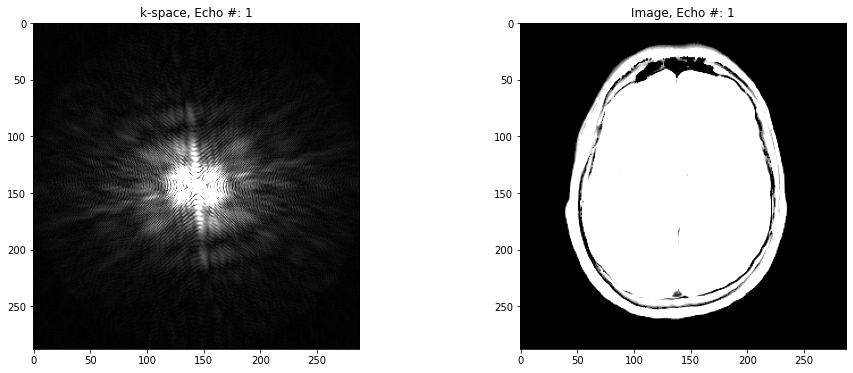

In [7]:
echo_index = 1
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(np.abs(brain_phantom_fft[:,:,0,0,0,echo_index]), cmap='gray',vmin=0,vmax = .0005)
plt.title('k-space, Echo #: ' + str(echo_index))
plt.subplot(1,2,2)
plt.imshow(np.abs(brain_phantom[:,:,0,0,0,echo_index]), cmap='gray',vmax = .00025,vmin=0)
plt.title('Image, Echo #: ' + str(echo_index))
plt.show()

coil_sens shape:  (288, 288, 1, 8)


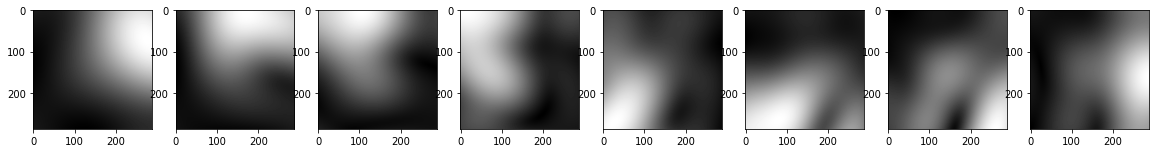

Coil Sensitivity images


In [8]:
#coil sensitivities in the image domain, because they are applied in image domain in the forward model

coil_sens = bart(1,'phantom -x 288 -S 8')#time domian sensitivities square right now
print('coil_sens shape: ',coil_sens.shape)

for index in range(8):
    plt.figure(1, figsize=(20,5))
    plt.subplot(1, 8, index+1)
    plt.imshow(np.abs(coil_sens[:,:,0,index]),cmap=plt.get_cmap('gray'))
plt.show()
print('Coil Sensitivity images')

coil_sens = bart(1,'normalize 8',coil_sens)#need to normalize the sensitivity maps along each coil

In [9]:
print(coil_sens.shape,brain_phantom.shape)

(288, 288, 1, 8) (288, 288, 1, 1, 1, 16)


In [10]:
#only multiply the sensitivity map in image space because this is where we have the forward model says
image_with_coil_sens = bart(1,'fmac',coil_sens,brain_phantom) #in image-space generate the data for the different coils 
image_with_coil_sens_fft = bart(1,'fft -u 3',image_with_coil_sens)#going to the k-space for all the coil images
print(image_with_coil_sens_fft.shape)

(288, 288, 1, 8, 1, 16)


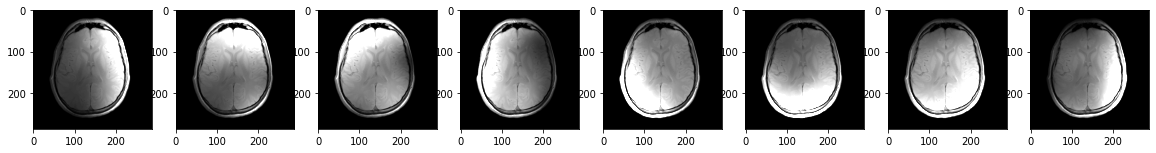

Brain images as acquired by different coils


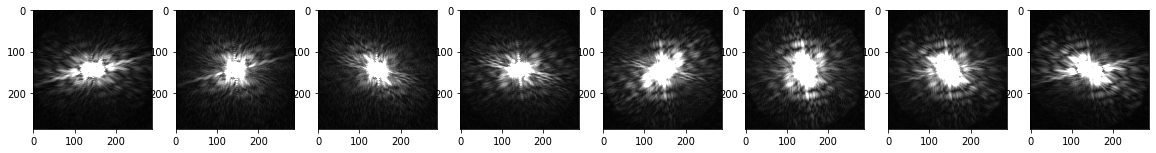

Brain images (in k-space) as acquired by different coils


In [11]:
for index in range(8):
    plt.figure(1, figsize=(20,5))
    plt.subplot(1, 8, index+1)
    plt.imshow(np.abs(image_with_coil_sens[:,:,0,index,0,0]),cmap=plt.get_cmap('gray'),vmin=0,vmax = .00025)
plt.show()
print('Brain images as acquired by different coils')
for index in range(8):
    plt.figure(1, figsize=(20,5))
    plt.subplot(1, 8, index+1)
    plt.imshow(np.abs(image_with_coil_sens_fft[:,:,0,index,0,0]),cmap=plt.get_cmap('gray'),vmin=0,vmax = .0001)
plt.show()
print('Brain images (in k-space) as acquired by different coils')

(288, 288)


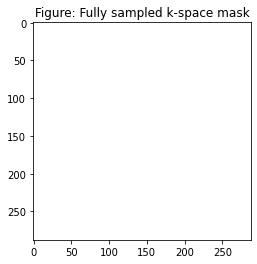

In [12]:
#!bart traj -h
kspace_mask = np.ones((288,288))
print(kspace_mask.shape)
plt.imshow(np.abs(kspace_mask[:,:]).squeeze(), cmap='gray',vmax = 1,vmin=0)
plt.title('Figure: Fully sampled k-space mask')
plt.show()

In [13]:
# #generating masks for fully sampling the k-space domain, uses the T2shuffling case
# kspace_mask = bart(1,'t2sh_gen_mask -Y 288 -Z 288 -d 1 -C 3 -V 5 -r 1 -T 1 -E 1 -F')
# kspace_mask = kspace_mask.squeeze()
# print(kspace_mask.shape)
# plt.imshow(np.abs(kspace_mask[:,:]).squeeze(), cmap='gray',vmax = 0.1,vmin=0)
# plt.title('Figure: Fully sampled k-space mask')
# plt.show()

In [14]:
#generating k-space data for the fully sampled case with 8 coils
fully_sampled_fft = bart(1,'fmac',image_with_coil_sens_fft,kspace_mask)
print(fully_sampled_fft.shape)

(288, 288, 1, 8, 1, 16)


In [15]:
np.save('fully_sampled_fft.npy',fully_sampled_fft.squeeze())

## Upto this point the forward problem is done for the case of fully sampled case, from next cell we will start working on the inverse problem
### The idea would be to first evaluate the coil sensitivities and then applying the iterative algorithm to force the model and evaluate the (T1,T2) parameters from this data. 

In [16]:
#estimating the coil sensitivity of each coil
k_space_coils_data = fully_sampled_fft[:,:,0,:,0,0].squeeze()
print(k_space_coils_data.shape)
#ecalib accepts a particular shape of input data hence the last step needed
coil_sens_estimated = bart(1, 'ecalib -m 8 -a -d 0', k_space_coils_data[:,:,None,:]).squeeze()
print(coil_sens_estimated.shape)#The fourth dimension here is spurious

(288, 288, 8)
(288, 288, 8, 8)


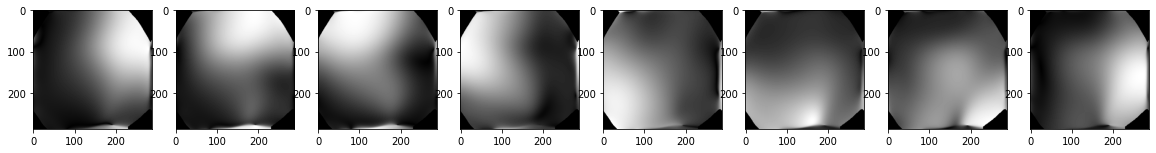

Estimated Coil Sensitivity images


In [17]:
for index in range(8):
    plt.figure(1, figsize=(20,5))
    plt.subplot(1, 8, index+1)
    plt.imshow(np.abs(coil_sens_estimated[:,:,index,0]),cmap=plt.get_cmap('gray'))
plt.show()
print('Estimated Coil Sensitivity images')

In [18]:
coil_sens_estimated = coil_sens_estimated[:,:,:,0]
coil_sens_estimated = coil_sens_estimated.squeeze()
coil_sens_estimated = coil_sens_estimated[:,:,None,:]
print(coil_sens_estimated.shape)

(288, 288, 1, 8)


In [19]:
!bart version

v0.7.00-49-g3f76f2f


In [20]:
pics_out = bart(1,'pics -R Q:0.005 -i 10 -S',fully_sampled_fft,coil_sens_estimated)
print(pics_out.shape)

(288, 288, 1, 1, 1, 16)


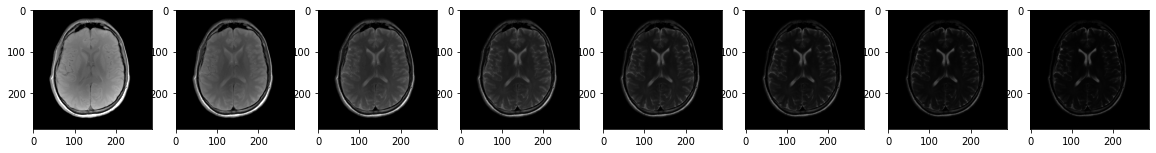

Brain images as acquired on different echoes


In [21]:
pics_out1 = pics_out.squeeze()
for index in range(8):
    plt.figure(1, figsize=(20,5))
    plt.subplot(1, 8, index+1)
    plt.imshow(np.abs(pics_out1[:,:,2*index]),cmap=plt.get_cmap('gray'),vmin=0,vmax = .001)
plt.show()
print('Brain images as acquired on different echoes')

In [22]:
brain_phantom_fft = bart(1,'fft -u -i 3',brain_phantom)#going to the k-space for all the coil images

In [42]:
pics_out_ksp = bart(1,'fft -u -i 3',pics_out)
print(pics_out_ksp.shape)

(288, 288, 1, 1, 1, 16)


In [24]:
print(fully_sampled_fft.shape)
print(coil_sens_estimated.shape)

(288, 288, 1, 8, 1, 16)
(288, 288, 1, 8)


In [25]:
TEs = (np.arange(16) +1) *18.2
print(TEs)
TEs = TEs[None,None,None,None,None,:]

[ 18.2  36.4  54.6  72.8  91.  109.2 127.4 145.6 163.8 182.  200.2 218.4
 236.6 254.8 273.  291.2]


In [26]:
!bart moba -h

Usage: moba [-r ...] [-L ...] [-F ...] [-G ...] [-m d] [-l d] [-i d] [-R f] [-T f] [-j f] [-u f] [-C d] [-s f] [-B f] [-b ...] [-d d] [-f f] [-p <string>] [-J] [-M] [-g] [-I <string>] [-t <string>] [-o f] [-k] [--kfilter-1 ...] [--kfilter-2 ...] [-n] [--fat_spec_0 ...] <kspace> <TI/TE> <output> [<sensitivities>]

Model-based nonlinear inverse reconstruction


-r <T>:A:B:C	generalized regularization options (-rh for help)
-L		T1 mapping using model-based look-locker
-F		T2 mapping using model-based Fast Spin Echo
-G		T2* mapping using model-based multiple gradient echo
-m model      	Select the MGRE model from enum { WF = 0, WFR2S, WF2R2S, R2S, PHASEDIFF } [default: WFR2S]
-l reg      	1/-l2	toggle l1-wavelet or l2 regularization.
-i iter      	Number of Newton steps
-R redu      	reduction factor
-T damp      	damping on temporal frames
-j minreg      	Minimum regu. parameter
-u rho      	ADMM rho [default: 0.01]
-C iter      	inner iterations
-s step      	step size
-B bound      	low

In [27]:
print(pics_out_ksp.shape,TEs.shape)

(288, 288, 1, 1, 1, 16) (1, 1, 1, 1, 1, 16)


(3, 288, 288, 1, 1, 16)


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


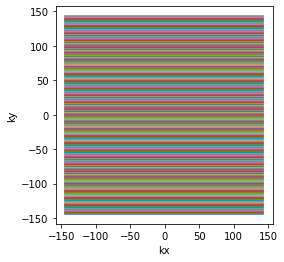

In [28]:
traj = bart(1, 'traj -x 288 -y 288 -e 16')
print(traj.shape)
#traj1 = np.ones()
plt.figure()
plt.plot(traj[0,:,:,0,0,0].squeeze(), traj[1,:,:,0,0,0].squeeze())

plt.axis('square')
plt.xlabel('kx')
plt.ylabel('ky')
plt.show()
#traj = traj = traj[:,:,:,:,:,None,:]

In [29]:
cfl.writecfl('coil_sens',coil_sens_estimated)
cfl.writecfl('fully_sampled_fft',fully_sampled_fft)
cfl.writecfl('TEs',TEs)
cfl.writecfl('pics_out_ksp',pics_out_ksp)
cfl.writecfl('T2_traj',traj)

In [30]:
print(pics_out_ksp.shape, TEs.shape)

(288, 288, 1, 1, 1, 16) (1, 1, 1, 1, 1, 16)


In [31]:
!bart moba -F -i2 -n -C300 -j0.1 -l2 -d5 pics_out_ksp TEs T2_maps 

Scaling: 27676.620741
Scaling_psf: 0.868056
[288 288   1   1   1   1   2   1   1   1   1   1   1   1   1   1 ]
[288 288   1   1   1  16   1   1   1   1   1   1   1   1   1   1 ]
[288 288   1   1   1  16   1   1   1   1   1   1   1   1   1   1 ]
[288 288   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
[288 288   1   1   1  16   1   1   1   1   1   1   1   1   1   1 ]
imgs_dims:
	[288 288   1   1   1   1   2   1   1   1   1   1   1   1   1   1 ]
[288 288   1   1   1   1   2   1   1   1   1   1   1   1   1   1 ]
Step: 0, Res: 4999.999826
##reg. alpha = 1.000000
#It 000: inf   
#It 001: nan   
#It 002: -nan   
#It 003: -nan   
#It 004: -nan   
#It 005: -nan   
#It 006: -nan   
#It 007: -nan   
#It 008: -nan   
#It 009: -nan   

		FISTA iterations: 10
Step: 1, Res: nan
##reg. alpha = 0.550000
#It 000: -nan   
#It 001: -nan   
#It 002: -nan   
#It 003: -nan   
#It 004: -nan   
#It 005: -nan   
#It 006: -nan   
#It 007: -nan   
#It 008: -nan   
#It 009: -nan   
#It 010: -nan   
#It 

In [32]:
T2_maps = cfl.readcfl('T2_maps')
print(T2_maps.shape)

(288, 288, 1, 1, 1, 1, 2)


In [33]:
# T2_maps = bart(1, 'moba -F -i1 -n -C10 -j0.001 -d2', pics_out_ksp, TEs, coil_sens_estimated).squeeze()

In [34]:
T2_maps = T2_maps.squeeze()
print(T2_maps.shape)
print(T2_maps)

(288, 288, 2)
[[[nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  ...
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]]

 [[nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  ...
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]]

 [[nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  ...
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]]

 ...

 [[nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  ...
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]]

 [[nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  ...
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]]

 [[nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  ...
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]
  [nan+nanj  0. +0.j]]]


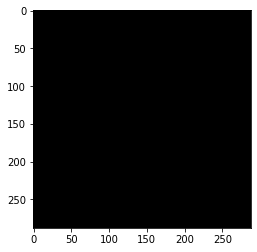

In [35]:
plt.imshow(np.abs(T2_maps[:,:,1]),cmap=plt.get_cmap('gray'))

In [36]:
!bart traj -h

Usage: traj [-x d] [-y d] [-d d] [-e d] [-a d] [-t d] [-m d] [-l] [-g] [-r] [-G] [-H] [-s d] [-D] [-R f] [-q ...] [-Q ...] [-O] [-3] [-c] [-E] [-z ...] [-C <string>] [-V <string>] <output>

Computes k-space trajectories.

-x x      	readout samples
-y y      	phase encoding lines
-d d      	full readout samples
-e e      	number of echoes
-a a      	acceleration
-t t      	turns
-m mb      	SMS multiband factor
-l		aligned partition angle
-g		golden angle in partition direction
-r		radial
-G		golden-ratio sampling
-H		halfCircle golden-ratio sampling
-s # Tiny GA      	tiny golden angle
-D		projection angle in [0,360°), else in [0,180°)
-R phi      	rotate
-q delays      	gradient delays: x, y, xy
-Q delays      	(gradient delays: z, xz, yz)
-O		correct transverse gradient error for radial tajectories
-3		3D
-c		asymmetric trajectory [DC sampled]
-E		multi-echo multi-spoke trajectory
-z Ref:Acel      	Undersampling in z-direction.
-C file      	custom_angle file [phi + i * psi]
-V file

(3, 288, 288, 1, 1, 16)


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


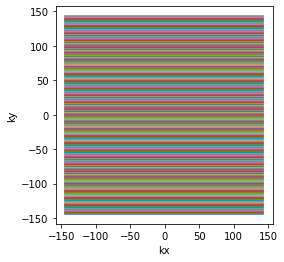

In [37]:
traj = bart(1, 'traj -x 288 -y 288 -e 16')
print(traj.shape)
#traj1 = np.ones()
plt.figure()
plt.plot(traj[0,:,:,0,0,0].squeeze(), traj[1,:,:,0,0,0].squeeze())

plt.axis('square')
plt.xlabel('kx')
plt.ylabel('ky')
plt.show()



In [38]:
pics_out1 = pics_out_ksp.squeeze()
print(pics_out1.shape)
pics_out_ksp_1 = pics_out1[None,:,:,None,None,:]
print(pics_out_ksp_1.shape,traj.shape,TEs.shape)

(288, 288, 16)
(1, 288, 288, 1, 1, 16) (3, 288, 288, 1, 1, 16) (1, 1, 1, 1, 1, 16)


In [39]:
!bart fft -h

Usage: fft [-u] [-i] [-n] bitmask <input> <output>

Performs a fast Fourier transform (FFT) along selected dimensions.

-u		unitary
-i		inverse
-n		un-centered
-h		help


In [40]:
def A_forward(img):
    print(TEs.shape,img.shape)
    img2 = np.exp(-1*bart(1,'fmac',TEs, img))
    print(img2.shape,traj.shape)
    return bart(1, 'fft -u 6', img2)

def A_adjoint(ksp):
    ksp_ifft = bart(1, 'fft -i 6', ksp)
    return 

In [41]:
temp = np.ones((288,288))
print(temp.shape)
temp2 = temp[None,:,:]
tt = A_forward(temp2)
print(tt.shape)

(288, 288)
(1, 1, 1, 1, 1, 16) (1, 288, 288)
(1, 288, 288, 1, 1, 16) (3, 288, 288, 1, 1, 16)
(1, 288, 288, 1, 1, 16)
